In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [7]:
# Define paths to metadata files and image directories
train_metadata_path = 'C:/Users/kelvi/Documents/Tensorflow/workspace_3/data/PV train.csv'
test_seen_metadata_path= 'C:/Users/kelvi/Documents/Tensorflow/workspace_3/data/PV test seen.csv'
test_unseen_metadata_path  = 'C:/Users/kelvi/Documents/Tensorflow/workspace_3/data/PV test unseen.csv'
pd_test_unseen_metadata_path = 'C:/Users/kelvi/Documents/Tensorflow/workspace_3/data/PD test unseen.csv'


In [8]:
plantvillage_dir = 'C:/Users/kelvi/Documents/Tensorflow/workspace_3/data/plantvillage'
plantdoc_dir  = 'C:/Users/kelvi/Documents/Tensorflow/workspace_3/data/plantdoc'

In [9]:
# Define image dimensions
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3  # RGB images
BATCH_SIZE = 32

In [10]:
# Load the metadata for training and testing
train_metadata = pd.read_csv(train_metadata_path)
test_seen_metadata = pd.read_csv(test_seen_metadata_path)
test_unseen_metadata = pd.read_csv(test_unseen_metadata_path)
pd_test_unseen_metadata = pd.read_csv(pd_test_unseen_metadata_path)

In [11]:
# Rename columns to make them consistent
train_metadata.columns = ['image_file_name', 'crop_category', 'disease_category']
test_seen_metadata.columns = ['image_file_name', 'crop_category', 'disease_category']
test_unseen_metadata.columns = ['image_file_name', 'crop_category', 'disease_category']
pd_test_unseen_metadata.columns = ['image_file_name', 'crop_category', 'disease_category']


In [12]:
# Use only the crop category as the label for classification
train_metadata['label'] = train_metadata['crop_category'].astype(str)
test_seen_metadata['label'] = test_seen_metadata['crop_category'].astype(str)
test_unseen_metadata['label'] = test_unseen_metadata['crop_category'].astype(str)
pd_test_unseen_metadata['label'] = pd_test_unseen_metadata['crop_category'].astype(str)

In [13]:
# Data Augmentation for Training Data
train_data_gen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)

In [14]:
# Testing Data Generator (only rescale, no augmentation)
test_data_gen = ImageDataGenerator(rescale=1.0 / 255.0)

In [15]:
# Function to generate data from a DataFrame
def dataframe_generator(df, base_dir, target_size, batch_size, data_gen, class_mode, label_column):
    return data_gen.flow_from_dataframe(
        dataframe=df,
        directory=base_dir,
        x_col='image_file_name',
        y_col=label_column,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=True
    )

In [16]:
# Generate training and testing data
train_data = dataframe_generator(train_metadata, plantvillage_dir, (IMG_HEIGHT, IMG_WIDTH), BATCH_SIZE, train_data_gen, 'categorical', 'label')
pv_test_seen_data = dataframe_generator(test_seen_metadata, plantvillage_dir, (IMG_HEIGHT, IMG_WIDTH), BATCH_SIZE, test_data_gen, 'categorical', 'label')
pv_test_unseen_data = dataframe_generator(test_unseen_metadata, plantvillage_dir, (IMG_HEIGHT, IMG_WIDTH), BATCH_SIZE, test_data_gen, 'categorical', 'label')
pd_test_unseen_data = dataframe_generator(pd_test_unseen_metadata, plantdoc_dir, (IMG_HEIGHT, IMG_WIDTH), BATCH_SIZE, test_data_gen, 'categorical', 'label')

Found 38993 validated image filenames belonging to 14 classes.
Found 10278 validated image filenames belonging to 14 classes.
Found 215 validated image filenames belonging to 1 classes.
Found 70 validated image filenames belonging to 1 classes.


In [17]:
# Define the number of classes
num_classes = len(train_data.class_indices)

In [18]:
# Section 4: Model Construction and Compilation (Updated)

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Define the CNN model architecture
def build_cnn_model(input_shape=(299, 299, 3), num_classes=num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [19]:
# Initialize and compile the model
cnn_model = build_cnn_model(input_shape=(299, 299, 3), num_classes=num_classes)
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [20]:
# Callbacks for learning rate adjustment and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


In [21]:
# Train the model
history = cnn_model.fit(
    train_data,
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    epochs=15,
    validation_data=pv_test_seen_data,
    validation_steps=pv_test_seen_data.samples // BATCH_SIZE,
    callbacks=[reduce_lr, early_stop]
)


Epoch 1/15
1218/1218 [==============================] - 545s 438ms/step - loss: 1.3605 - accuracy: 0.5711 - val_loss: 0.7376 - val_accuracy: 0.7721 - lr: 0.0010
Epoch 2/15
1218/1218 [==============================] - 517s 424ms/step - loss: 0.8257 - accuracy: 0.7305 - val_loss: 0.4565 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 3/15
1218/1218 [==============================] - 502s 412ms/step - loss: 0.6542 - accuracy: 0.7889 - val_loss: 0.3721 - val_accuracy: 0.8743 - lr: 0.0010
Epoch 4/15
1218/1218 [==============================] - 468s 385ms/step - loss: 0.5581 - accuracy: 0.8192 - val_loss: 0.3141 - val_accuracy: 0.8943 - lr: 0.0010
Epoch 5/15
1218/1218 [==============================] - 468s 384ms/step - loss: 0.4832 - accuracy: 0.8423 - val_loss: 0.2363 - val_accuracy: 0.9201 - lr: 0.0010
Epoch 6/15
1218/1218 [==============================] - 467s 383ms/step - loss: 0.4376 - accuracy: 0.8594 - val_loss: 0.1606 - val_accuracy: 0.9482 - lr: 0.0010
Epoch 7/15
1218/1218 [============

In [ ]:
# Save the model as an H5 file
cnn_model.save('final_model3.h5', save_format='h5')
print("Final model saved as 'final_model3.h5'")


In [23]:
# Evaluate on PV Unseen Test Set
pv_test_unseen_data.reset()
pv_unseen_loss, pv_unseen_accuracy = cnn_model.evaluate(pv_test_unseen_data)
print(f"PlantVillage Unseen Test Set Accuracy: {pv_unseen_accuracy:.4f}")

7/7 [==============================] - 2s 220ms/step - loss: 230.3197 - accuracy: 0.1256
PlantVillage Unseen Test Set Accuracy: 0.1256


In [24]:
# Evaluation
print("Evaluating on PV Seen Test Set:")
pv_seen_loss, pv_seen_accuracy = cnn_model.evaluate(pv_test_seen_data)
print(f"PlantVillage Seen Test Set Accuracy: {pv_seen_accuracy:.4f}")

Evaluating on PV Seen Test Set:
322/322 [==============================] - 32s 99ms/step - loss: 0.1039 - accuracy: 0.9698
PlantVillage Seen Test Set Accuracy: 0.9698


In [25]:
# Evaluate on PD Unseen Test Set
pd_test_unseen_data.reset()
pd_unseen_loss, pd_unseen_accuracy = cnn_model.evaluate(pd_test_unseen_data)
print(f"PlantDoc Unseen Test Set Accuracy: {pd_unseen_accuracy:.4f}")

3/3 [==============================] - 1s 336ms/step - loss: 399.9084 - accuracy: 0.0857
PlantDoc Unseen Test Set Accuracy: 0.0857


In [26]:
# Harmonic Mean Calculation
harmonic_mean_accuracy = 2 * (pv_seen_accuracy * pv_unseen_accuracy) / (pv_seen_accuracy + pv_unseen_accuracy)
print(f"Harmonic Mean Accuracy between Seen and Unseen: {harmonic_mean_accuracy:.4f}")

Harmonic Mean Accuracy between Seen and Unseen: 0.2224


In [27]:
# Top-N accuracy calculation function
def top_n_accuracy(predictions, true_labels, n=5):
    top_n_preds = np.argsort(predictions, axis=1)[:, -n:]
    return np.mean([true_labels[i] in top_n_preds[i] for i in range(len(true_labels))])

In [28]:
# Predict and evaluate Top-1 and Top-5 accuracies
pv_test_unseen_data.reset()
predictions = cnn_model.predict(pv_test_unseen_data, steps=pv_test_unseen_data.samples // BATCH_SIZE + 1)
predicted_classes = predictions.argmax(axis=1)
true_classes = pv_test_unseen_data.classes

7/7 [==============================] - 1s 98ms/step


In [29]:
top_1_accuracy = top_n_accuracy(predictions, true_classes, n=1)
top_5_accuracy = top_n_accuracy(predictions, true_classes, n=5)
print(f"Top-1 Accuracy: {top_1_accuracy:.4f}")
print(f"Top-5 Accuracy: {top_5_accuracy:.4f}")

Top-1 Accuracy: 0.1256
Top-5 Accuracy: 0.7860


Evaluating on PV Seen Test Set:
322/322 [==============================] - 31s 96ms/step


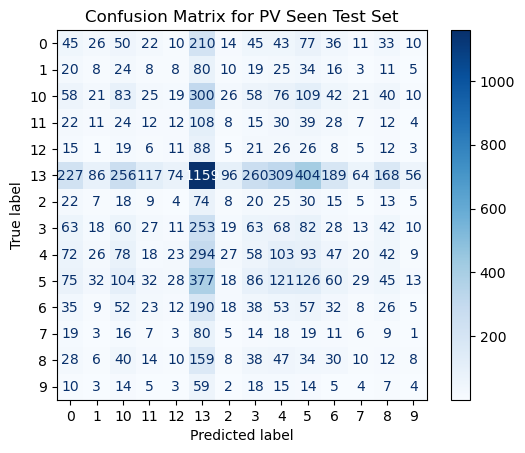

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate on PV Seen Test Set
print("Evaluating on PV Seen Test Set:")
pv_test_seen_data.reset()
predictions = cnn_model.predict(pv_test_seen_data, steps=pv_test_seen_data.samples // BATCH_SIZE + 1)
predicted_classes = predictions.argmax(axis=1)
true_classes = pv_test_seen_data.classes

# Generate Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pv_test_seen_data.class_indices.keys())

# Plot Confusion Matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for PV Seen Test Set")
plt.show()


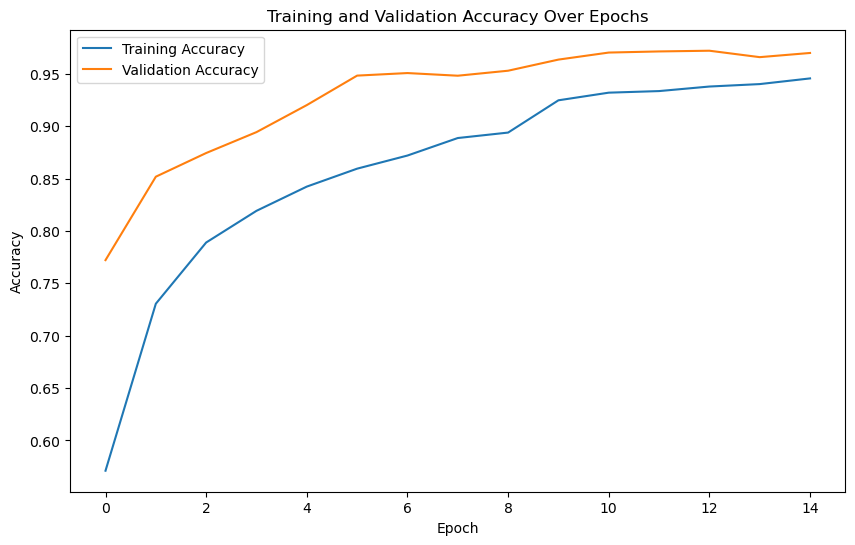

In [31]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()